Title: Decision Trees and their Hyperparameters 
Date: 2019-04-21
Tags: python 
Slug: decision-trees

Decision Trees, also referred to as CART (Classification and Regression Trees), are one of the most popular and well understood machine learning algorithms. Decision trees are super intuitive and interpretable because they mimic how the human brain works. 

That said, decision trees may lag behind other, more complex machine learning algorithms (sometimes called 'black box algorithms') in accuracy. However, in many situations, like in the context of a business where you can't make certain decisions without being able to explain why (think of a bank giving out loans to individuals), interpretability is preferred over accuracy. 

### Decision Tree Basics
---

Decision trees are essentially a bunch of **if-then-else** rules stacked on top of each other. Here is a silly example:

#### <center> Question: Should I write this blog post? </center>

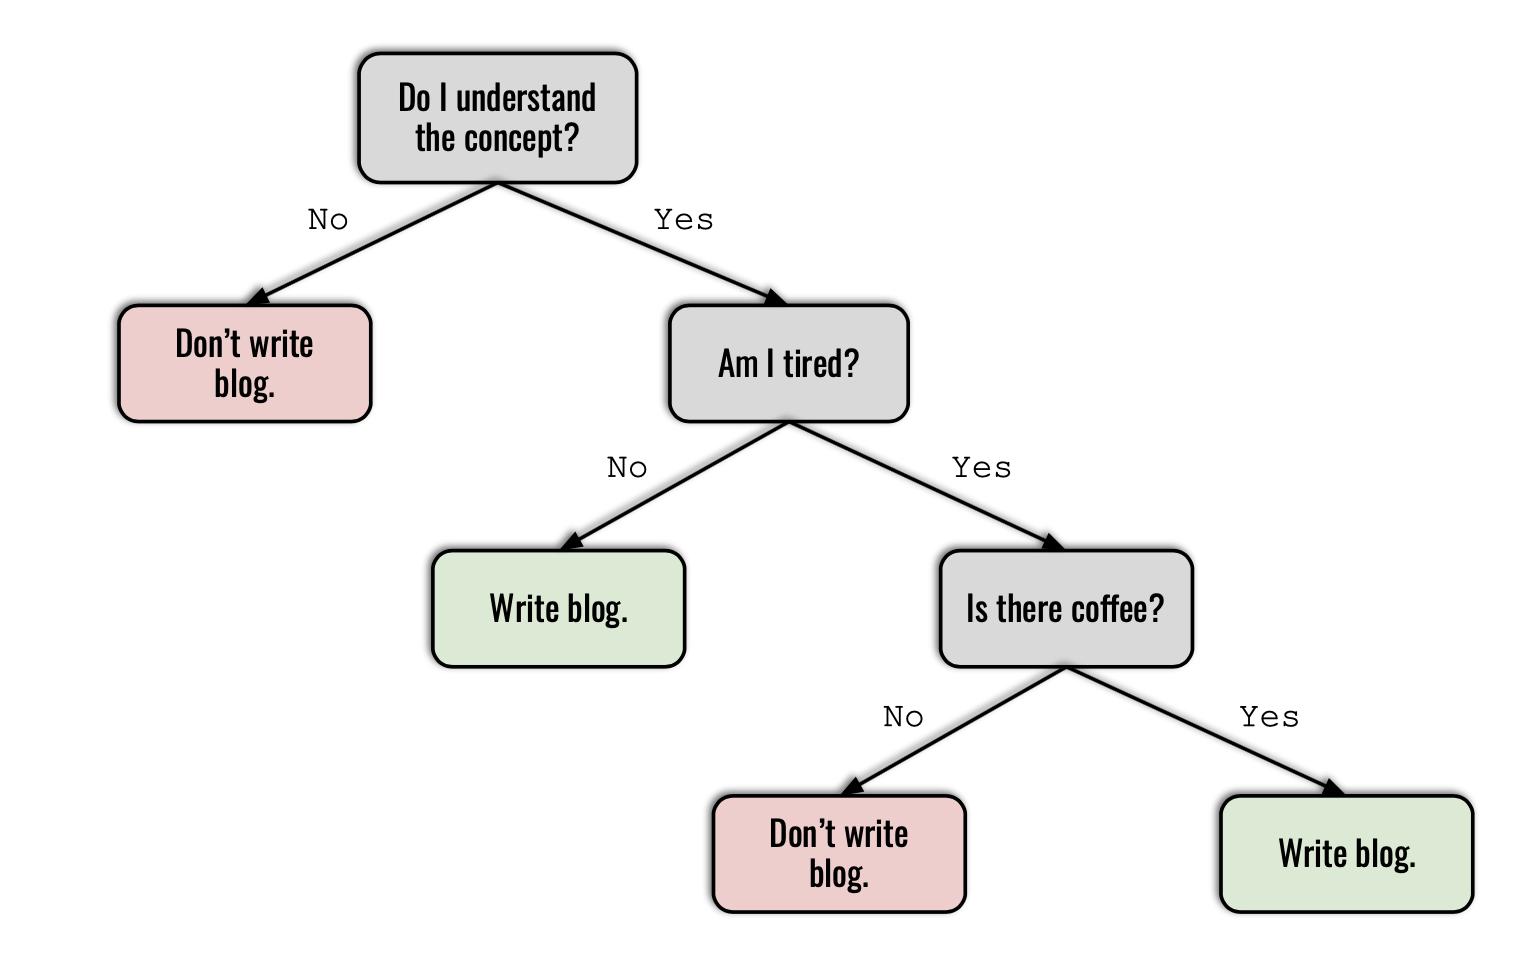

In [42]:
from IPython.display import Image, HTML
Image(filename='decision_tree.png', width=600)

* "*Do I understand the concept?*" is the **root node**. 
* "*Am I tired?*" and "*Is there coffee?*" are **internal nodes**. 
* The colored boxes are **leaf nodes** and they store the target variable, i.e. the prediction made by the algorithm.
* The arrows pointing from internal nodes to leaf nodes are **branches**. 
* Nodes that precede other nodes are called **parent nodes**. Nodes that immediately proceed them are referred to as their **children**. "*Am I tired*?" and "*Don't write blog*" are the children of "*Do I understand the concept?*". 
* The **depth** of a tree is length of the longest path from the root node to a leaf node. The decision tree above has a depth of 3.

The decision tree algorithm operates by coming up with rules and partitioning the data accordingly at each node in a **sequential** manner. But how does the algorithm figure out the logical order of rules? In the above case, how can it know that my understanding of the concept is the number one question that must be answered yes, before any other thing such as whether or not there is coffee?

Answer: with the help of some good old math! Decision trees are built in a top-down fashion through finding the attribute that maximizes something called **information gain** at each split. The idea is that, the higher the information gain, the higher the importance of the attribute in determining the outcome/target variable. Decision trees are often called a **greedy** algorithm since they find the best partition each individual step, rather than optimizing for a global tree structure that will deliver the best prediction.

The formula for information gain is as follows:

$$
\begin{eqnarray*}
\text{Information Gain} &=& E(\text{parent})  - \sum_{\text{children}}\frac{N_j}{N}E(\text{children}_j) 
\end{eqnarray*}
$$

This can look intimidating at first but it's actually quite simple. The function E() is something called **entropy**. To compute information gain, we simply deduct the weighted sum of the entropies of the children nodes from the entropy of the parent node. The attribute that yields the highest information gain when partioned to its children gets chosen as the root node. This process continues with the remaining subset of data until there is no way to further partition the tree, which is when there is one class left in each leaf node. When that is the case, the decision tree is considered complete. 

Entropy measures the amount of unpredictability in a random variable. In practical terms, it is a measure of **impurity** of an attribute. If the attribute in question is composed of a single class, for example, all yes's or all no's, then that attribute is considered **pure** and entropy takes on a value of 0. If the classes are equally distributed, for example, 50% yes's and 50% no's, entropy takes on a value of 1. 

Here is the formula for entropy:

$$
\begin{eqnarray*}
\text{Entropy} &=& \sum_{i=1}^{classes} - {P_i} * {log_2}{P_i}
\end{eqnarray*}
$$

Entropy and information gain are used interchangeably with something called **gini index**, a slightly different measure of node impurity. They yield very similar results. 

To better understand how decision trees work, let's manually rebuild one. 

In [66]:
import numpy as np
import pandas as pd

blog_post = pd.DataFrame({'conceptual_understanding': ['No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'],
                          'am_i_tired': ['No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes'],
                          'is_there_coffee': ['No', 'No', 'No', 'No', 'No', 'No', 'No','Yes', 'Yes', 'No'],
                          'write_blog': ['No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
                         })

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split

# preprocessing the data
mapper = DataFrameMapper([
    ('conceptual_understanding', LabelEncoder()),
    ('am_i_tired', LabelEncoder()),
    ('is_there_coffee', LabelEncoder()),
    ('write_blog', LabelEncoder())
], df_out=True)

blog_post = mapper.fit_transform(blog_post)

X = blog_post.iloc[:, :-1]
y = blog_post['write_blog']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

Check out [my previous blog post](https://dunyaoguz.github.io/my-blog/dataframemapper.html) on DataFrameMapper for more information on how it works.

In [43]:
# instantiate the Decision Tree
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
dt.score(X_test, y_test)

1.0

A perfect score! Our Decision Tree Classifier can predict whether I'm going to write a blog post or not with 100% accuracy. Let's see how the algorithm partitioned the data.

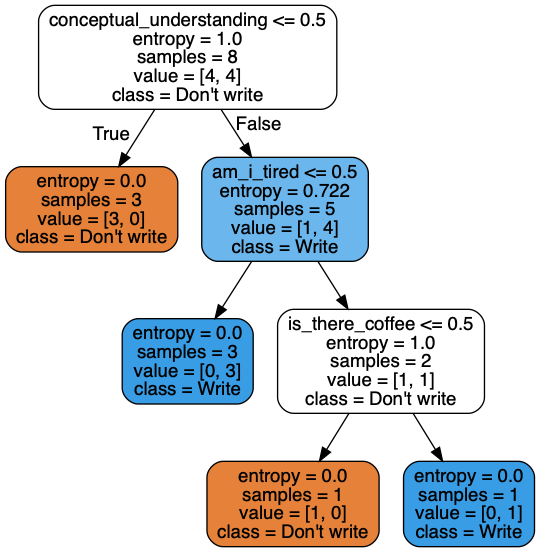

In [77]:
from IPython.display import Image  
import pydotplus
from sklearn import tree

dot_data = tree.export_graphviz(
    dt, 
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=X_train.columns,
    class_names=['Don\'t write', 'Write'])

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png(), width=300)

We see that the algorithm was able to produce the exact same order of rules I came up with through logic, with math. Here, we can also see the number of samples that got partitioned at each node, along with the entropies that were calculated. Now, let's redo this manually.

**Step one:** We have 100% of the train data (8 samples). Our train dataset includes 3 variables: `conceptual_understanding`, `am_i_tired` and `is_there_coffee`. 

In [16]:
train_data = X_train.merge(y_train, how='inner', on=X_train.index).set_index('key_0')

HTML(train_data.head().to_html(classes="table table-stripped table-hover"))

,conceptual_understanding,am_i_tired,is_there_coffee,write_blog
key_0,,,,
5,1,0,0,1
0,0,0,0,0
7,1,1,1,1
2,0,0,0,0
9,1,1,0,0


In [50]:
# Define Entropy function.
def entropy(y):
    y = list(y)
    unique_elements = set(y)
    entropy_sum = []
    # Iterate through each class.
    for element in unique_elements:
        # Calculate observed probability of class i
        prob = (y.count(element) / len(y))
        # Perform the entropy formula
        entropy_sum.append(prob * np.log2(prob))
    return -sum(entropy_sum)

In [61]:
# Define Information Gain function.
def information_gain(df, column):
    # Calculate parent_entropy
    parent_entropy = entropy(df['write_blog'])
    # Calculate the weighted sum of child entropies
    child_0_entropy = entropy(df[df[column] == 0]['write_blog'])
    child_1_entropy = entropy(df[df[column] == 1]['write_blog'])
    child_0_count = len(df[df[column] == 0]['write_blog'])
    child_1_count = len(df[df[column] == 1]['write_blog'])
    child_entropy_weighted_sum = child_0_entropy * child_0_count/len(df['write_blog']) + child_1_entropy * child_1_count/len(df['write_blog'])
    # Return information gain
    return parent_entropy - child_entropy_weighted_sum

Let's calculate the information gain for each 3 variables at the root node.

In [53]:
print(f'Parent entropy: {entropy(train_data.write_blog)}\n')
print('Information gain at the root node:\n')
a = information_gain(train_data, 'conceptual_understanding')
b = information_gain(train_data, 'am_i_tired')
c = information_gain(train_data, 'is_there_coffee')
print(f'\t1. conceptual_understanding: {round(a, 3)}')
print(f'\t2. am_i_tired: {round(b, 3)}')
print(f'\t3. is_there_coffee: {round(c, 3)}')

Parent entropy: 1.0

Information gain at the root node:

	1. conceptual_understanding: 0.549
	2. am_i_tired: 0.049
	3. is_there_coffee: 0.138


Since `conceptual_understanding` yields the highest information gain, we choose it as the root node. The 3 rows for which `conceptual_understanding` is no assume a target value of `don't write`. 

**Step 2:** We recalculate information gain for the other 5 rows for which `conceptual_understanding` is yes.

In [54]:
# get the remaining data
remaining_data = train_data[train_data['conceptual_understanding'] != 0]

# calculate information gain for the remaining data
print(f'Parent entropy: {round(entropy(remaining_data.write_blog), 3)}\n')
print('Information gain at the first internal node:\n')
a = information_gain(remaining_data, 'conceptual_understanding')
b = information_gain(remaining_data, 'am_i_tired')
c = information_gain(remaining_data, 'is_there_coffee')
print(f'\t1. conceptual_understanding: {round(a, 3)}')
print(f'\t2. am_i_tired: {round(b, 3)}')
print(f'\t3. is_there_coffee: {round(c, 3)}')

Parent entropy: 0.722

Information gain at the first internal node:

	1. conceptual_understanding: 0.0
	2. am_i_tired: 0.322
	3. is_there_coffee: 0.073


Notice how information gain for `conceptual_understanding` is now 0, since all rows have a value of yes. In non-math terms, this variable is no longer useful in determining the outcome of whether I write the blog post or not. Since `am_i_tired` has the highest information gain here, we select it as the first internal node. The 3 rows for which `am_i_tired` is no assume a target value of `write`. 

**Step 3:** We recalculate information gain for the remaining 2 rows, where both `conceptual_understanding` and `am_i_tired` are yes. 

In [55]:
# get the remaining data
remaining_data_2 = remaining_data[remaining_data['am_i_tired'] != 0]

# calculate information gain for the remaining data
print(f'Parent entropy: {entropy(remaining_data_2.write_blog)}\n')
print('Information gain at the second internal node:\n')
a = information_gain(remaining_data_2, 'conceptual_understanding')
b = information_gain(remaining_data_2, 'am_i_tired')
c = information_gain(remaining_data_2, 'is_there_coffee')
print(f'\t1. conceptual_understanding: {round(a, 3)}')
print(f'\t2. am_i_tired: {round(b, 3)}')
print(f'\t3. is_there_coffee: {round(c, 3)}')

Parent entropy: 1.0

Information gain at the second internal node:

	1. conceptual_understanding: 0.0
	2. am_i_tired: 0.0
	3. is_there_coffee: 1.0


Now, `is_there_coffee` has the highest information gain because the other two variables no longer impact the outcome. If `is_there_coffee` is no, the target variable is `don't write`. If `is_there_coffee` is yes, the target variable is `write`. Since there is no way to further partition the tree at this point, our decision tree is complete.

This example illustrated how decision trees work with a binary classification problem, but the principles and concepts shown here apply to decision tree regressors as well. 

### Hyperparameters of Decision Trees
----

Now that we understand how decision trees work, let's talk about their **hyperparameters**.

In machine learning, **hyperparameters** are built in model configurations whose values are specified before the learning process begins. They are independent from the data on which the model is fit and can be *tuned* as desired. 

Hyperparameters can dramatically change the performance of a model, and finding the combination of hyperparameters that yield the best performance is a common component of machine learning workflows. 

Let's examine the hyperparameters available in decision trees.

* `criterion`: Measure of impurity that will be used to partition the data. Options = [gini, entropy]. Default = gini.

* `splitter`: The strategy used to split the decision tree at each node. If this is set to random, a random value is partitioned at each node instead of the attribute that yields the highest information gain or gini impurity. Options = [best, random]. Default = best.

* `max_depth`: The maximum length of the longest path from the root node to a leaf node. Unless max depth is specified, decision tree will automatically extend until all leaf nodes are pure or contain less than `min_samples_split` samples. Options = [None, int]. Default = None.

* `min_samples_split`: The minimum number of samples required to partition a node. If we had set `min_samples_split` to 3 when we instantiated the model above, the data would not be partitioned at `is_there_coffee` since only 2 samples remained at that node. Options = [int, float]. Default = 2.

* `min_samples_leaf`: The minimum number of samples required to be a leaf node. Data will not be partitioned at a node if any of its children to the right or left would have less samples than min_samples_leaf. As an example, if I had specified `min_samples_leaf` as 2, the data would not be split at `is_there_coffee` because both of its children have 1 sample. Options = [int, float]. Default = 1.

* `max_features`: The maximum number of features to consider when looking for the best split. In the above example, we calculated information gain for all 3 features in the dataset at each partition. If `max_features` was specified as 2, information gain would be computed for only 2 of the features at each split. Options = [None, int, string, float]. Default = None.

* `max_leaf_nodes`: Maximum number of leaf nodes that can exist in the decision tree. If it is specified, the decision tree stops partitioning once it reaches the set number of leaf nodes. Options = [None, int]. Default = None.

* `min_impurity_decrease`: Minimum amount of decrease in impurity that needs to be induced by partitioning a node. If the decrease in impurity would be less than `min_impurity_decrease`, the said partition does not occur. Options = [None, float]. Default = None.

### Tree based ensemble methods 
----

Decision trees tend to suffer from overfitting and perform poorly on unseen data. Tree based ensemble methods combine several decision trees in order to improve the predictive performance of stand alone decision trees. Here, I'm going to talk about two techniques: **bootstrap aggregated trees** and **random forests**.

Bootstrap aggregated trees, or bagging trees in short, withdraw several random samples from the dataset with replacement, and train a decision tree on each sample. When given a new dataset, bagging trees calculate the predictions by averaging the results from each bootstrapped decision tree. 

Random forests also build various decision trees on bootstrapped resamples from the original dataset, but differently than bagged trees, random forests only consider a subset of the features at each iteration. With bagging, the decision trees in the aggregation tend to be strongly correlated to each other since each tree includes all of the original features. The selection of features at random (called the **random subspace method**) in random forests counters the correlation between trees, resulting in an overall model that performs better on unseen data. It is typical to use $\sqrt{p}$ features in each split in a Random Forest Classifier, and $p/3$ features in a Random Forest Regressor.

### Hyperparameters of ensemble methods
----

The hyperparameters of bagging trees and random forests are exactly the same as the hyperparameters of decision trees, with a few additions.

* `n_estimators`: The number of trees in the ensemble. Options = [int]. Default = 10. (The default option for Random Forest will change to 100 in the new version of sklearn.)

* `bootstrap`: Whether samples are drawn with replacement. Options = [True, False]. Default = True. This argument should never be set to False as drawing samples without replacement would be equivalent to duplicating the original dataset.

* `n_jobs`: The number of processors to run while training the model and computing predictions from it. If set to 1, no parallel computing code is used. If set to -1, all CPUs are used. Options = [None, int]. Default = None.

* `oob_score`: On average, each bootstrapped sample uses about 2/3 of the observations. The remaining 1/3 of the observations not used to fit a given bootstrapped tree are referred to as the out-of-bag (OOB) observations. If this argument is set to true, OOB observations are used to score the performance each tree in the ensemble. Options = [True, False]. Default = False.

* `verbose`: If set to true, the output for each decision tree in the ensemble gets printed. Options = [True, False]. Default = False.